In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
from IPython.display import Image, HTML

In [2]:
# -------------------------------------------------
# Matplotlib settings for thicker lines & bigger fonts
# -------------------------------------------------
plt.rcParams.update({
    'font.size': 18,          # Default text size
    'axes.labelsize': 18,     # Axis label size
    'axes.titlesize': 20,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'lines.linewidth': 2,     # Thicker lines by default
    'lines.markersize': 9,
    'axes.linewidth': 2,
    'xtick.major.size': 10,
    'xtick.major.width': 2,
    'ytick.major.size': 10,
    'ytick.major.width': 2,
    'xtick.minor.size': 5,
    'xtick.minor.width': 1,
    'ytick.minor.size': 5,
    'ytick.minor.width': 1
})


# Helium Temperature Scale

Before we can do any analysis, we need to be able to convert between pressure and temperature for Helium 4. 

For this, given measured datapoints from the He4 scale of 1958, we will fit a polynomial and use this as our temperature scale.

$$
T = a_0 + a_1 \log(P) + a_2 \log^2(P) + \dots

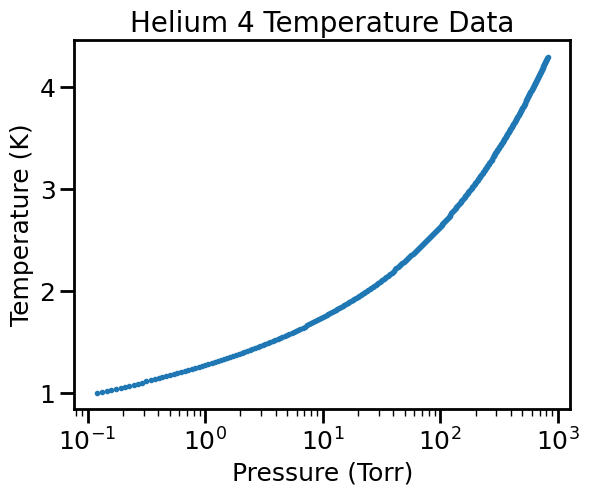

In [3]:
# we load the data from the Wiki (obtained from the 1958 scale)
temperature_scale = np.loadtxt("../Data/helium_temperature_scale.txt")
equilibrium_vapor_pressures = temperature_scale[:,0]/1000 # we divide by 100 to convert to Tors
equilibrium_temperatures = temperature_scale[:,1]


plt.plot(equilibrium_vapor_pressures, equilibrium_temperatures, 'o', markersize=3)

plt.xscale('log')

plt.xlabel('Pressure (Torr)')
plt.ylabel('Temperature (K)')
plt.title('Helium 4 Temperature Data')
plt.show()

In [4]:
# we now fit a polynomial like explained above

lnP = np.log(equilibrium_vapor_pressures)
T   = equilibrium_temperatures

degree =5
coeffs = np.polyfit(lnP, T, deg=degree)

# we define a function with the parameters of our model
def helium_T_of_P(P):
    """
    Returns the temperature (K) given a vapor pressure P (Pa),
    based on a polynomial fit in ln(P).
    """
    return np.polyval(coeffs, np.log(P))


# we evaluate the model by computing the RMS error
fit_values = helium_T_of_P(equilibrium_vapor_pressures)
errors = fit_values - T
rms_error = np.sqrt(np.mean(errors**2))

print(f"RMS error: {rms_error:.6f} K")

RMS error: 0.001111 K


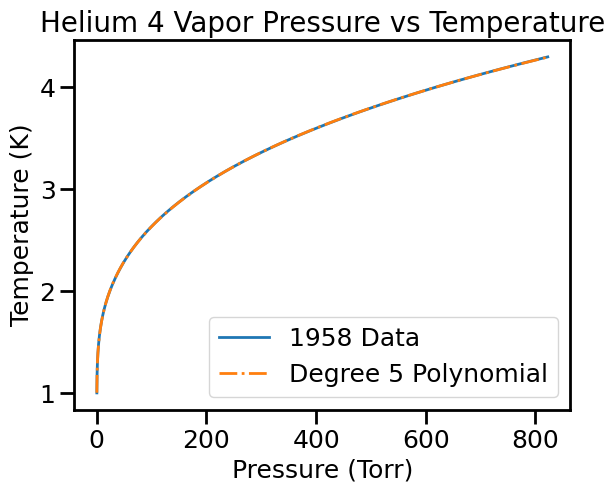

In [5]:
# compare the model to the data for a visual check
plt.figure()
plt.plot(equilibrium_vapor_pressures, equilibrium_temperatures, '-', label='1958 Data')

plt.plot(equilibrium_vapor_pressures, fit_values, '-.', label='Degree 5 Polynomial')

plt.xlabel('Pressure (Torr)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Helium 4 Vapor Pressure vs Temperature')
plt.show()

# Germanium Thermometer Calibration

In [6]:
ge_df = pd.read_excel('../Data/HeatCapacity/compiledHeatCapacityData.xlsx', sheet_name='Sheet2')
ge_df.head()

,Pressure (mTorr),Voltage (mV)
0,775.0,0.629
1,770.0,0.632
2,760.0,0.636
3,750.0,0.640
4,745.0,0.645


In [7]:
ge_temperatures = [helium_T_of_P(p) for p in ge_df['Pressure (mTorr)']]
ge_voltages = ge_df['Voltage (mV)']

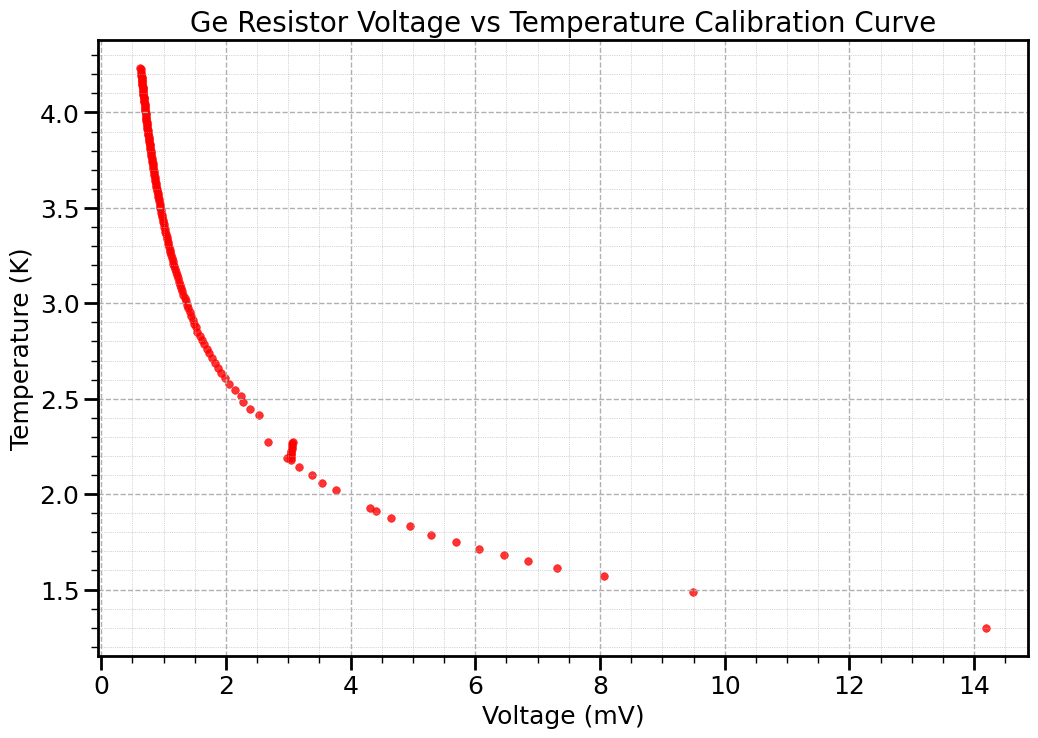

In [8]:

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(ge_voltages,
           ge_temperatures,
           s=30, color='red', linewidths=0.5, alpha=0.8)


ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Voltage (mV)')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('Ge Resistor Voltage vs Temperature Calibration Curve')

ax.grid(True, which='major', linestyle='--', linewidth=1)
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)

ax.minorticks_on()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.show()

In [9]:
lnT = np.log(ge_temperatures)
lnV  = np.log(ge_voltages)

degree = 2
ge_coeffs = np.polyfit(lnV, lnT , deg=degree)

# we define a function with the parameters of our model
def germanium_T_of_V(V):
    """
    Return T (K) from a power-law fit:
    ln(T) = c0 + c1 * ln(V).
    """
    lnT_fit = np.polyval(ge_coeffs, np.log(V)) 
    return np.exp(lnT_fit)  # Convert ln(T) back to T


# we evaluate the model by computing the RMS error
predictions = germanium_T_of_V(ge_voltages)

errors = predictions - ge_temperatures
rms_error = np.sqrt(np.mean(errors**2))

print(f'Fit coefficients: {ge_coeffs}')
print(f"RMS error: {rms_error:.6f} K")

Fit coefficients: [ 0.02499667 -0.42887621  1.23420355]
RMS error: 0.018912 K


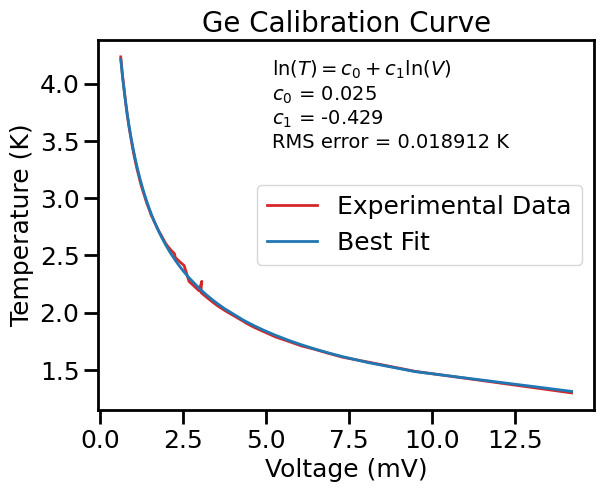

In [10]:
plt.plot(ge_voltages, ge_temperatures, color='tab:red', label = 'Experimental Data')
plt.plot(ge_voltages, predictions, color='tab:blue', label = 'Best Fit')
# plt.loglog()

plt.title('Ge Calibration Curve')
plt.xlabel('Voltage (mV)')
plt.ylabel('Temperature (K)')

# Build a text string displaying the equation and fit parameters
equation_text = r"$\ln(T) = c_0 + c_1 \ln(V)$"  # The equation in LaTeX form
params_text = (rf"$c_0$ = {ge_coeffs[0]:.3f}" + "\n"
               rf"$c_1$ = {ge_coeffs[1]:.3f}" + "\n"
               f"RMS error = {rms_error:.6f} K")

text_string = equation_text + "\n" + params_text

# Place the text box within the axes
plt.text(
    0.35, 0.95, text_string,
    transform=plt.gca().transAxes,
    verticalalignment='top',
    fontsize=14,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.0)
)

plt.legend()
plt.show()

# Empty Calorimetry Cell Data Processing

In [ ]:
# First, we load the experimental data
empty_cell_data = np.loadtxt('../Data/HeatCapacity/helium heat capacity/runs/emptycell_run3')

empty_cell_data